In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from matplotlib import pyplot as plt

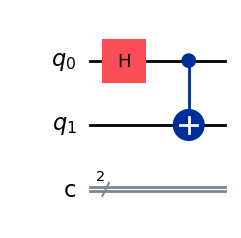

In [12]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2, 2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

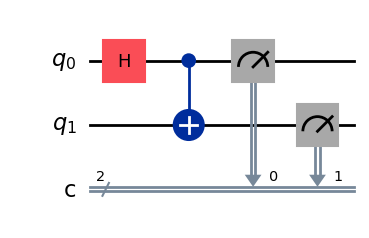

In [13]:
qc.measure([0,1],[0,1])
qc.draw("mpl")

In [8]:
service = QiskitRuntimeService()
for bend in service.backends(simulator=False, operational=True):
    print(f"{bend.name}: {bend.status().pending_jobs} jobs in the queue & {bend.num_qubits} qubits")

ibm_fez: 3 jobs in the queue & 156 qubits
ibm_marrakesh: 875 jobs in the queue & 156 qubits
ibm_torino: 2 jobs in the queue & 133 qubits


In [9]:
backend = service.least_busy(simulator=False, operational=True)
#backend = service.get_backend('iibm_brisbane')  # Example for a specific backend

## 🔍 Understanding Observable Labels

In the experiment, we measure **expectation values** of different **Pauli observables** to analyze quantum correlations between qubits.

| Observable | Meaning | Description |
|-------------|----------|--------------|
| **IZ** | Identity ⊗ Pauli-Z | Measures only the second qubit in the computational (Z) basis; ignores the first. |
| **ZI** | Pauli-Z ⊗ Identity | Measures only the first qubit in the Z basis; ignores the second. |
| **IX** | Identity ⊗ Pauli-X | Measures only the second qubit in the X basis; ignores the first. |
| **XI** | Pauli-X ⊗ Identity | Measures only the first qubit in the X basis; ignores the second. |
| **ZZ** | Pauli-Z ⊗ Pauli-Z | Joint measurement of both qubits in the Z basis — shows correlation in computational states (|00⟩ or |11⟩). |
| **XX** | Pauli-X ⊗ Pauli-X | Joint measurement of both qubits in the X basis — shows correlation in superposition states (|++⟩ or |––⟩). |

**Note:**  
Pauli operators {X, Y, Z} correspond to different measurement axes on the **Bloch sphere**:
- **Z:** vertical axis (|0⟩ / |1⟩ basis)  
- **X:** horizontal axis (|+⟩ / |–⟩ basis) 

In [50]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

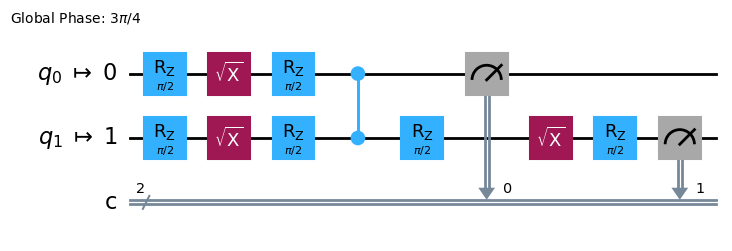

In [14]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

In [52]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 1024
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d3v83cmjbaoc73cpto40


In [53]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [54]:
from qiskit.visualization import plot_histogram

## 📈 Interpreting the Graph Results

The plot displays **expectation values** ⟨O⟩ for each observable **O**.  
These values range between –1 and +1 and indicate how strongly measurement outcomes correlate between qubits.

**Key observations from the plot:**

1. **IZ, IX, ZI, XI ≈ 0**  
   - Each individual qubit appears **random** when measured alone.  
   - This confirms that each qubit’s local state is mixed — a typical property of an **entangled system**.

2. **ZZ ≈ +1**  
   - Strong correlation in the **Z basis**: both qubits yield the same outcome (00 or 11).  
   - Indicates that the system is **not separable** — measuring one immediately defines the other.

3. **XX ≈ +1**  
   - Strong correlation in the **X basis** as well: both qubits give matching |+⟩ or |–⟩ results.  
   - Confirms **quantum entanglement**, since such simultaneous correlations in two incompatible bases (Z and X) are impossible classically.

---

## ✅ Conclusion

The data pattern matches the theoretical signature of the **Bell state**:

\[
|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
\]

This indicates that:
- The **Hadamard + CNOT** sequence successfully created an entangled pair.  
- The qubits are **maximally correlated** in both Z and X bases.  
- The near-zero single-qubit expectations (IZ, XI, etc.) and near-unity joint correlations (ZZ, XX) are clear evidence of **quantum entanglement**.


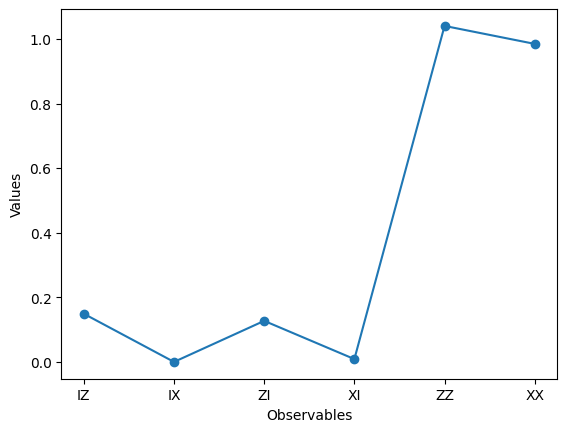

In [55]:
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

In [ ]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=1024)
result = jobSampler.result()
print("Result:", result)

Result: PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-11-07 21:13:33', stop='2025-11-07 21:13:34', size=1024>)])}, 'version': 2})


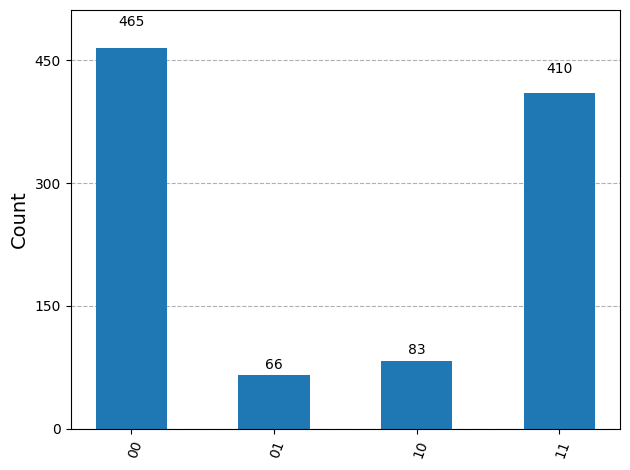

In [24]:
from qiskit.visualization import plot_histogram
plot_histogram(result[0].data.c.get_counts())